## 詞庫手法

In [1]:
import nltk

In [2]:
nltk.download('wordnet')

[nltk_data] Error loading wordnet: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


False

In [5]:
from nltk.corpus import wordnet as wn
wn.synsets('motorcar')

[Synset('car.n.01')]

In [6]:
wn.synsets('trunk')

[Synset('trunk.n.01'),
 Synset('trunk.n.02'),
 Synset('torso.n.01'),
 Synset('luggage_compartment.n.01'),
 Synset('proboscis.n.02')]

In [7]:
wn.synset('car.n.01').lemma_names()

['car', 'auto', 'automobile', 'machine', 'motorcar']

## 計數手法

In [8]:
s = 'you say goodbye and I say hello. '

In [20]:
import numpy as np
text = s
text = text.lower()
words = text.split()
words_to_id = {}
id_to_words = {}
for idx, word in enumerate(words):
    words_to_id[word] = idx
    id_to_words[idx] = word
words_to_id
id_to_words

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'say', 6: 'hello.'}

In [16]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    corpus = np.array([word_to_id[w] for w in words])
    return corpus, word_to_id, id_to_word

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)


In [17]:
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [18]:
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [19]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [23]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
    return co_matrix

In [24]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)

In [26]:
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [25]:
C = create_co_matrix(corpus, vocab_size)
C

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

In [28]:
def cos_similarity(x, y, eps=1e-8):
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)


In [29]:
c0 = C[word_to_id['you']]
c0

array([0, 1, 0, 0, 0, 0, 0], dtype=int32)

In [30]:
c1 = C[word_to_id['i']]
c1

array([0, 1, 0, 1, 0, 0, 0], dtype=int32)

In [31]:
cos_similarity(c0, c1)

0.7071067691154799

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
cs = cosine_similarity(C)

In [34]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    
    # 1. 列出Query
    if query not in word_to_id:
        print('%s is not found' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    # 2. 計算Cosine Similarity
    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
        
    # 3. 從cosine similarity 由高到低列出數值結果
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

In [36]:
most_similar('you', word_to_id, id_to_word, C)


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


In [41]:
from sklearn.metrics.pairwise import cosine_distances
cs = cosine_distances(C)

In [48]:
for idx in cs[0].argsort()[1:6]:
    print(id_to_word[idx], cs[0][idx])

goodbye 0.29289321881345254
i 0.29289321881345254
hello 0.29289321881345254
say 1.0
and 1.0


In [49]:
def ppmi(C, verbose=False, eps = 1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M

In [51]:
W = ppmi(C)

In [52]:
W

array([[0.       , 1.8073549, 0.       , 0.       , 0.       , 0.       ,
        0.       ],
       [1.8073549, 0.       , 0.8073549, 0.       , 0.8073549, 0.8073549,
        0.       ],
       [0.       , 0.8073549, 0.       , 1.8073549, 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 1.8073549, 0.       , 1.8073549, 0.       ,
        0.       ],
       [0.       , 0.8073549, 0.       , 1.8073549, 0.       , 0.       ,
        0.       ],
       [0.       , 0.8073549, 0.       , 0.       , 0.       , 0.       ,
        2.807355 ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 2.807355 ,
        0.       ]], dtype=float32)

In [54]:
# SVD
U, S, V = np.linalg.svd(W)

In [55]:
W.shape

(7, 7)

In [58]:
U.shape, S.shape, V.shape

((7, 7), (7,), (7, 7))

Populating the interactive namespace from numpy and matplotlib


/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


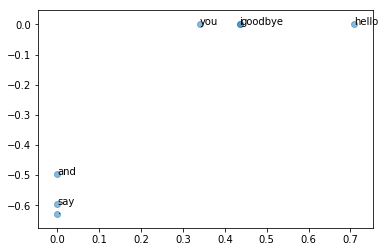

In [59]:
%pylab inline
from matplotlib import pyplot as plt
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()